In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [22]:
df = pd.read_csv('../src/data/gold/teste_indicium_precificacao_OHE.csv')
data = df.copy()

# Precisamos entender nossa variável alvo e como os dados se organizam no nosso dataset

In [23]:
data.describe()

,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,media_bairro,bairro_group__Bronx,bairro_group__Brooklyn,bairro_group__Manhattan,bairro_group__Queens,bairro_group__Staten Island,room_type__Entire home/apt,room_type__Private room,room_type__Shared room
count,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000
mean,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.090928,7.144005,112.776169,152.720763,0.022314,0.411155,0.443020,0.115883,0.007629,0.519675,0.456600,0.023725
std,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.597294,32.952855,131.618692,62.297599,0.147703,0.492048,0.496748,0.320088,0.087010,0.499618,0.498118,0.152192
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,47.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,107.678244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000,143.802806,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000,188.948276,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,800.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


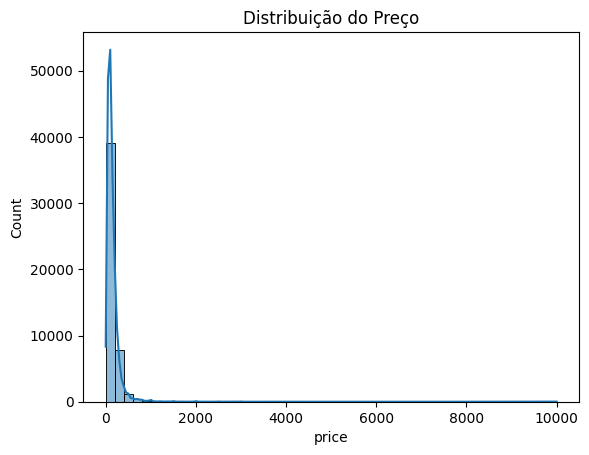

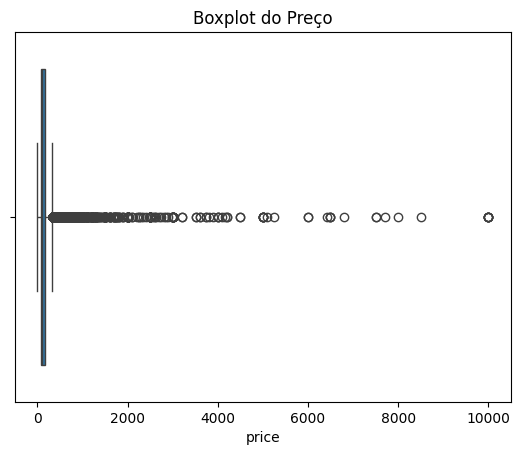

In [24]:
sns.histplot(data['price'], bins=50, kde=True)
plt.title('Distribuição do Preço')
plt.show()

sns.boxplot(x=data['price'])
plt.title('Boxplot do Preço')
plt.show()

## A distribuição está muito irregular, com muitos dados proximos de 0

Algumas abordagens podem ser aplicadas:
* Transformação Logarítmica

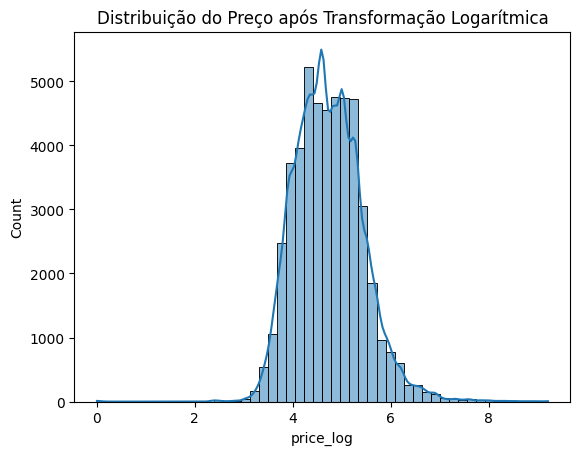

In [25]:
data['price_log'] = np.log1p(data['price'])  # log(1 + price) para evitar log(0)

# Para reverter para o valor original
# data['price_reverted'] = np.expm1(data['price_log'])

sns.histplot(data['price_log'], bins=50, kde=True)
plt.title('Distribuição do Preço após Transformação Logarítmica')
plt.show()


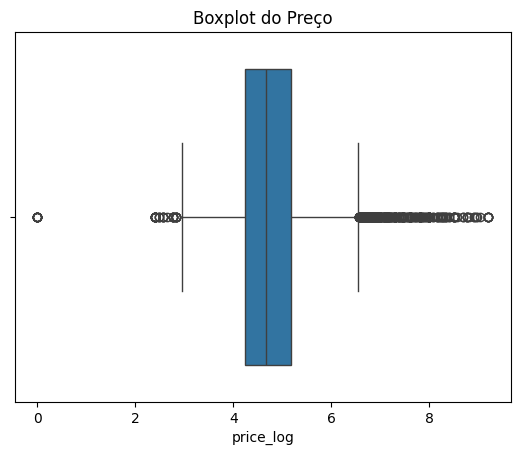

In [26]:
sns.boxplot(x=data['price_log'])
plt.title('Boxplot do Preço')
plt.show()

# Criação do modelo e testes de acurácia e precisão

In [27]:
data.head(3)

,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,media_bairro,bairro_group__Bronx,bairro_group__Brooklyn,bairro_group__Manhattan,bairro_group__Queens,bairro_group__Staten Island,room_type__Entire home/apt,room_type__Private room,room_type__Shared room,price_log
0,2845,40.75362,-73.98377,225,1,45,0.38,2,355,282.719094,0,0,1,0,0,1,0,0,5.420535
1,4632,40.80902,-73.94190,150,3,0,0.00,1,365,118.974041,0,0,1,0,0,0,1,0,5.017280
2,4869,40.68514,-73.95976,89,1,270,4.64,1,194,181.893357,0,1,0,0,0,1,0,0,4.499810


## Como nosso objetivo é 1 variável alvo numérica e de predição, utilizaremos um modelo regressor

In [28]:
x_data = data.drop(columns=['price','price_log'])
y_data = data['price_log']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)


### Regressão Linear

In [29]:
model_linear = LinearRegression()
model_linear.fit(x_train, y_train)

y_pred = model_linear.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Raiz do MSE
r2 = r2_score(y_test, y_pred)

# Exibindo os resultados
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 0.34
MSE: 0.22
RMSE: 0.47
R² Score: 0.54


### Random Forest

In [30]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 0.31
MSE: 0.19
RMSE: 0.43
R² Score: 0.60


### XGboost

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xg_reg.fit(x_train, y_train)

y_pred = xg_reg.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 0.31
MSE: 0.18
RMSE: 0.43
R² Score: 0.61


# Nosso melhor modelo foi o XGBoost

In [32]:
with open("../src/models/xg_reg_model.pkl", "wb") as f:
    pickle.dump(xg_reg, f)